# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Data Exploration and model for fresh vegetables in Italy 2006-2021
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).



In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
fresh_veg = pd.read_csv('final_data_notebooks/fresh-veg_final_2006-2021.csv',skipinitialspace=True)
fresh_veg.head()

City   Type_crop  Year  production_tonnes  total_area_ha    PS    TS  \
0  Agrigento  artichokes  2006           34020.00        3240.00 96.87 16.70   
1  Agrigento  artichokes  2006           34020.00        3240.00 96.87 16.70   
2  Agrigento  artichokes  2006           34020.00        3240.00 96.87 16.70   
3  Agrigento  artichokes  2006           34020.00        3240.00 96.87 16.70   
4  Agrigento  artichokes  2006           34020.00        3240.00 96.87 16.70   

   QV2M  RH2M  WS2M  ...  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  T2M_RANGE  \
0  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
1  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
2  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
3  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
4  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   

   PRECTOTCORR     Type_fertilizer  Fertilizers_tonnes   lat   lon  
0         1.58   calcium cyanamide                0.00 37.31 13.58  
1         1.58  nitrogen-potassium               27.70 37.31 13.58  
2         1.58         peaty-amend              174.50 37.31 13.58  
3         1.58    organic-nitrogen              760.50 37.31 13.58  
4         1.58             organic             1343.70 37.31 13.58  

[5 rows x 22 columns]

## Pre-processing dataset 

In [3]:
def show_info(fresh_veg):
    print('DATASET SHAPE: ',fresh_veg.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(fresh_veg.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(fresh_veg.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(fresh_veg.isnull().sum())
show_info(fresh_veg)

DATASET SHAPE:  (525117, 22) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525117 entries, 0 to 525116
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   City                525117 non-null  object 
 1   Type_crop           525117 non-null  object 
 2   Year                525117 non-null  int64  
 3   production_tonnes   525117 non-null  float64
 4   total_area_ha       525117 non-null  float64
 5   PS                  525117 non-null  float64
 6   TS                  525117 non-null  float64
 7   QV2M                525117 non-null  float64
 8   RH2M                525117 non-null  float64
 9   WS2M                525117 non-null  float64
 10  GWETTOP             525117 non-null  float64
 11  T2M_MAX             525117 non-null  float64
 12  T2M_MIN             525117 non-null  float64
 13  GWETPROF            525117 non-n

In [4]:
fresh_veg.describe()

Year  production_tonnes  total_area_ha        PS        TS  \
count 525117.00          525117.00      525117.00 525117.00 525117.00   
mean    2013.67            4380.11         127.34     93.83     14.40   
std        4.56           33198.88         547.88     20.38      4.10   
min     2006.00               0.00           0.00      0.00      0.00   
25%     2010.00              68.70           0.00     96.70     12.90   
50%     2014.00             344.20          10.00     98.63     15.35   
75%     2018.00            1850.00          72.00     99.78     16.92   
max     2021.00         1800000.00       23600.00    101.70     20.32   

           QV2M      RH2M      WS2M   GWETTOP   T2M_MAX   T2M_MIN  GWETPROF  \
count 525117.00 525117.00 525117.00 525117.00 525117.00 525117.00 525117.00   
mean       7.68     69.48      2.21      0.60     24.23      5.55      0.60   
std        1.86     15.21      0.93      0.15      5.65      3.63      0.15   
min        0.00      0.00      0.00      0.00      0.00     -8.91      0.00   
25%        7.35     70.56      1.55      0.56     23.71      3.10      0.57   
50%        7.98     72.47      2.11      0.63     25.40      5.61      0.62   
75%        8.57     74.51      2.70      0.69     26.71      7.89      0.67   
max       10.60     82.11      4.70      0.89     30.90     14.27      0.85   

       GWETROOT  CLOUD_AMT  T2M_RANGE  PRECTOTCORR  Fertilizers_tonnes  \
count 525117.00  525117.00  525117.00    525117.00           525117.00   
mean       0.61      49.08      18.67         2.03             1842.54   
std        0.15      12.51       5.23         0.74             4402.24   
min        0.00       0.00       0.00         0.00                0.00   
25%        0.58      45.59      16.54         1.61               42.00   
50%        0.63      50.98      20.41         2.03              309.00   
75%        0.69      56.12      21.97         2.43             1497.90   
max        0.84      74.91      26.54         4.99            98671.60   

            lat       lon  
count 525117.00 525117.00  
mean      42.08     12.24  
std        5.02      2.87  
min        0.00      0.00  
25%       40.67     10.32  
50%       42.85     12.24  
75%       44.84     14.24  
max       46.17     18.17

## Total fresh_veg production in 2006-2021

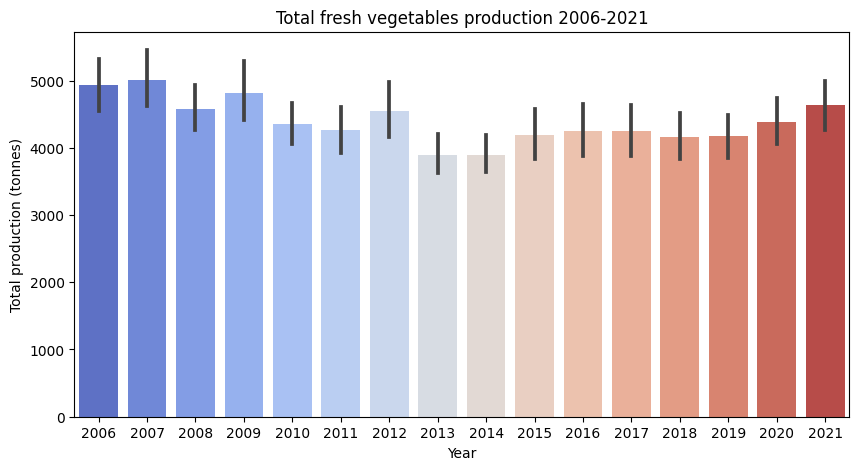

In [5]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'production_tonnes',data =fresh_veg,palette='coolwarm')
plt.title('Total fresh vegetables production 2006-2021')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes)')
plt.show()



## Cereal production by Cities 

In [6]:
fresh_veg_region =fresh_veg.groupby(by =fresh_veg.City)['production_tonnes','City'].sum().reset_index().sort_values(by = 'production_tonnes', ascending = False).head(10)
fresh_veg_region

City  production_tonnes
33     Foggia       322469128.00
43     Latina       211571668.00
71   Piacenza       122118031.00
85    Salerno       114541250.00
31    Ferrara       107112571.00
20    Caserta        68199753.00
50    Mantova        64492158.00
77     Ragusa        58378577.00
15   Brindisi        53169087.00
0   Agrigento        53001910.00

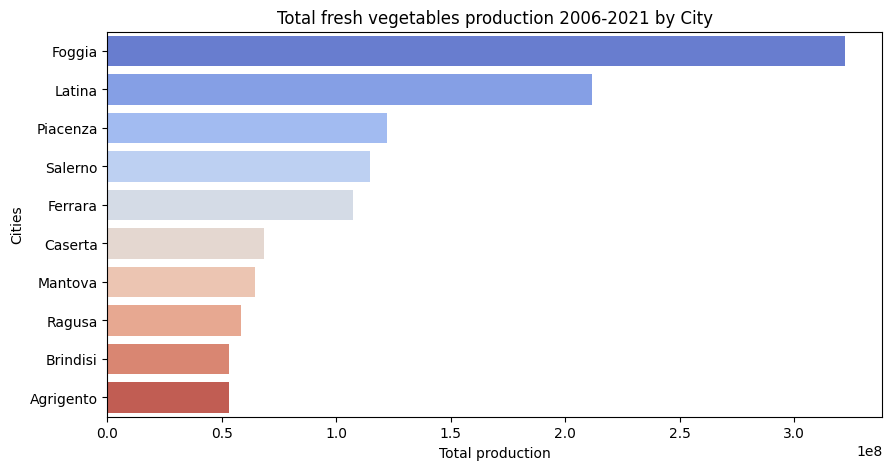

In [7]:
plt.figure(figsize= (10,5))
sns.barplot(x=fresh_veg_region['production_tonnes'],y=fresh_veg_region['City'], orient='h', palette='coolwarm');
plt.title('Total fresh vegetables production 2006-2021 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

##fresh_veg highest production 2006-2021

In [8]:
print(fresh_veg.Type_crop.max())
print(fresh_veg.Type_crop.value_counts())
print(fresh_veg.Type_crop.nunique())



white cabbage
courgette in open field                                        15942
lettuce in open field                                          15398
cauliflower and broccoli in open field                         14848
fresh beans in open field                                      14822
onions in open field                                           14298
                                                               ...  
red cabbage                                                      180
shallots in open field                                           110
other leafy or stalked vegetables n.e.c. (excluding chards)       60
other fresh vegetables n.e.c. (excluding broad beans)             30
tomato for process in greenhouse                                  30
Name: Type_crop, Length: 69, dtype: int64
69


In [9]:
print(fresh_veg.total_area_ha.max())
print(fresh_veg.total_area_ha.min())
print(fresh_veg.total_area_ha.value_counts())
print(fresh_veg.total_area_ha.nunique())


23600.0
0.0
0.00       162101
1.00        17311
2.00        16707
3.00        14598
5.00        14508
            ...  
1757.00        10
2320.00        10
958.00         10
1380.00        10
1990.00         1
Name: total_area_ha, Length: 1343, dtype: int64
1343


In [10]:
fresh_veg.drop(fresh_veg[fresh_veg['total_area_ha'] == 0.00 ].index , inplace=True)

In [11]:
fresh_veg.describe().astype(int)

Year  production_tonnes  total_area_ha      PS      TS    QV2M  \
count  363016             363016         363016  363016  363016  363016   
mean     2013               5422            184      93      14       7   
std         4              39288            650      20       4       1   
min      2006                  0              1       0       0       0   
25%      2010                120              8      96      12       7   
50%      2014                550             31      98      15       7   
75%      2018               2650            140      99      17       8   
max      2021            1800000          23600     101      20      10   

         RH2M    WS2M  GWETTOP  T2M_MAX  T2M_MIN  GWETPROF  GWETROOT  \
count  363016  363016   363016   363016   363016    363016    363016   
mean       69       2        0       24        5         0         0   
std        15       0        0        5        3         0         0   
min         0       0        0        0       -8         0         0   
25%        70       1        0       23        3         0         0   
50%        72       2        0       25        5         0         0   
75%        74       2        0       26        8         0         0   
max        82       4        0       30       14         0         0   

       CLOUD_AMT  T2M_RANGE  PRECTOTCORR  Fertilizers_tonnes     lat     lon  
count     363016     363016       363016              363016  363016  363016  
mean          48         18            2                1797      41      12  
std           12          5            0                4325       5       2  
min            0          0            0                   0       0       0  
25%           45         16            1                  42      40      10  
50%           50         20            2                 302      42      12  
75%           55         22            2                1447      44      14  
max           74         26            4               98671      46      18

In [12]:
# rename 

fresh_veg = fresh_veg.replace('courgette in open field','courgette-field')
fresh_veg = fresh_veg.replace('fresh beans in open field','fresh-beans-field')
fresh_veg = fresh_veg.replace('lettuce in open field','lettuce-field')                                            
fresh_veg = fresh_veg.replace('onions in open field','onions-field')
fresh_veg = fresh_veg.replace('tomato for fresh consumption','fresh-tomato')
fresh_veg = fresh_veg.replace('melon in open field','melon-field')
fresh_veg = fresh_veg.replace('egg-plant in open field','egg-plant-field')
fresh_veg = fresh_veg.replace('chicory in open field','chicory-field')
fresh_veg = fresh_veg.replace('red pepper in open field','red-pepper-field')
fresh_veg = fresh_veg.replace('cauliflower and broccoli in open field','cauliflower&broccoli-field')



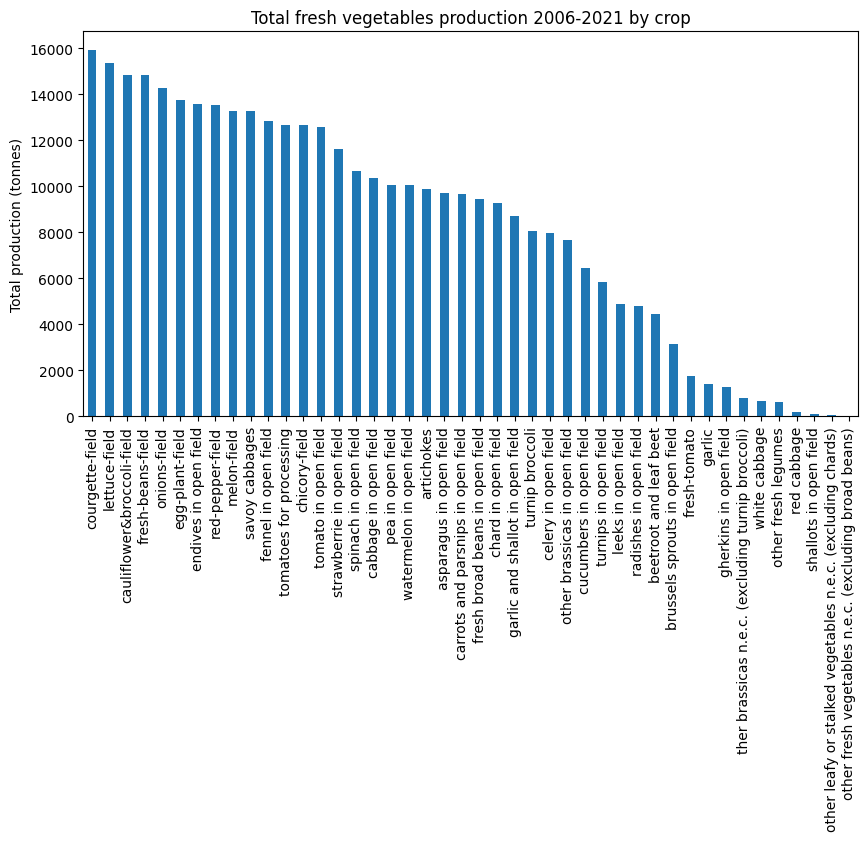

In [13]:
plt.figure(figsize=(10,5))
fresh_veg['Type_crop'].value_counts().plot.bar()
plt.title('Total fresh vegetables production 2006-2021 by crop')
plt.ylabel('Total production (tonnes)')
plt.show()


## Subseting data

In [14]:
fresh_veg

City                 Type_crop  Year  production_tonnes  \
0          Agrigento                artichokes  2006           34020.00   
1          Agrigento                artichokes  2006           34020.00   
2          Agrigento                artichokes  2006           34020.00   
3          Agrigento                artichokes  2006           34020.00   
4          Agrigento                artichokes  2006           34020.00   
...              ...                       ...   ...                ...   
525112  Sud Sardegna  watermelon in open field  2021           10386.80   
525113  Sud Sardegna  watermelon in open field  2021           10386.80   
525114  Sud Sardegna  watermelon in open field  2021           10386.80   
525115  Sud Sardegna  watermelon in open field  2021           10386.80   
525116  Sud Sardegna  watermelon in open field  2021           10386.80   

        total_area_ha     PS    TS  QV2M  RH2M  WS2M  ...  T2M_MIN  GWETPROF  \
0             3240.00  96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
1             3240.00  96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
2             3240.00  96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
3             3240.00  96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
4             3240.00  96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
...               ...    ...   ...   ...   ...   ...  ...      ...       ...   
525112         161.00 100.92 19.17 10.55 76.47  4.35  ...    13.52      0.56   
525113         161.00 100.92 19.17 10.55 76.47  4.35  ...    13.52      0.56   
525114         161.00 100.92 19.17 10.55 76.47  4.35  ...    13.52      0.56   
525115         161.00 100.92 19.17 10.55 76.47  4.35  ...    13.52      0.56   
525116         161.00 100.92 19.17 10.55 76.47  4.35  ...    13.52      0.56   

        GWETROOT  CLOUD_AMT  T2M_RANGE  PRECTOTCORR     Type_fertilizer  \
0           0.62      39.63      21.74         1.58   calcium cyanamide   
1           0.62      39.63      21.74         1.58  nitrogen-potassium   
2           0.62      39.63      21.74         1.58         peaty-amend   
3           0.62      39.63      21.74         1.58    organic-nitrogen   
4           0.62      39.63      21.74         1.58             organic   
...          ...        ...        ...          ...                 ...   
525112      0.58      49.54      10.26         2.78  nitrogen-potassium   
525113      0.58      49.54      10.26         2.78    organic-nitrogen   
525114      0.58      49.54      10.26         2.78             organic   
525115      0.58      49.54      10.26         2.78         peaty-amend   
525116      0.58      49.54      10.26         2.78         peaty-amend   

        Fertilizers_tonnes   lat   lon  
0                     0.00 37.31 13.58  
1                    27.70 37.31 13.58  
2                   174.50 37.31 13.58  
3                   760.50 37.31 13.58  
4                  1343.70 37.31 13.58  
...                    ...   ...   ...  
525112              113.00  0.00  0.00  
525113              221.00  0.00  0.00  
525114                0.00  0.00  0.00  
525115                0.00  0.00  0.00  
525116                0.00  0.00  0.00  

[363016 rows x 22 columns]

In [15]:
fresh_veg_top10 = fresh_veg.apply(lambda row: row[fresh_veg['Type_crop'].isin(['courgette-field', 'fresh-beans-field',
                                                                                         'lettuce-field','onions-field',
                                                                                         'cauliflower&broccoli-field',
                                                                                        'fresh-tomato','melon-field','egg-plant-field',
                                                                                         'chicory-field','red-pepper-field'])])

fresh_veg_top10.head()

City                   Type_crop  Year  production_tonnes  \
30  Agrigento  cauliflower&broccoli-field  2006            6708.00   
31  Agrigento  cauliflower&broccoli-field  2006            6708.00   
32  Agrigento  cauliflower&broccoli-field  2006            6708.00   
33  Agrigento  cauliflower&broccoli-field  2006            6708.00   
34  Agrigento  cauliflower&broccoli-field  2006            6708.00   

    total_area_ha    PS    TS  QV2M  RH2M  WS2M  ...  T2M_MIN  GWETPROF  \
30         312.00 96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
31         312.00 96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
32         312.00 96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
33         312.00 96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
34         312.00 96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   

    GWETROOT  CLOUD_AMT  T2M_RANGE  PRECTOTCORR     Type_fertilizer  \
30      0.62      39.63      21.74         1.58   calcium cyanamide   
31      0.62      39.63      21.74         1.58  nitrogen-potassium   
32      0.62      39.63      21.74         1.58         peaty-amend   
33      0.62      39.63      21.74         1.58    organic-nitrogen   
34      0.62      39.63      21.74         1.58             organic   

    Fertilizers_tonnes   lat   lon  
30                0.00 37.31 13.58  
31               27.70 37.31 13.58  
32              174.50 37.31 13.58  
33              760.50 37.31 13.58  
34             1343.70 37.31 13.58  

[5 rows x 22 columns]

In [16]:
Q1 = fresh_veg_top10.quantile(0.25)
Q3 = fresh_veg_top10.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Year                    8.00
production_tonnes    3540.00
total_area_ha         169.00
PS                      3.22
TS                      4.13
QV2M                    1.23
RH2M                    4.03
WS2M                    1.16
GWETTOP                 0.13
T2M_MAX                 3.06
T2M_MIN                 4.92
GWETPROF                0.10
GWETROOT                0.11
CLOUD_AMT              10.47
T2M_RANGE               5.48
PRECTOTCORR             0.82
Fertilizers_tonnes   1375.00
lat                     4.17
lon                     3.93
dtype: float64


In [17]:
# Remove outliers
fresh_veg_top10 = fresh_veg_top10[~((fresh_veg_top10 < (Q1 - 1.5 * IQR)) | (fresh_veg_top10 > (Q3 + 1.5 * IQR))).any(axis=1)]
print(fresh_veg_top10.shape)


(87797, 22)


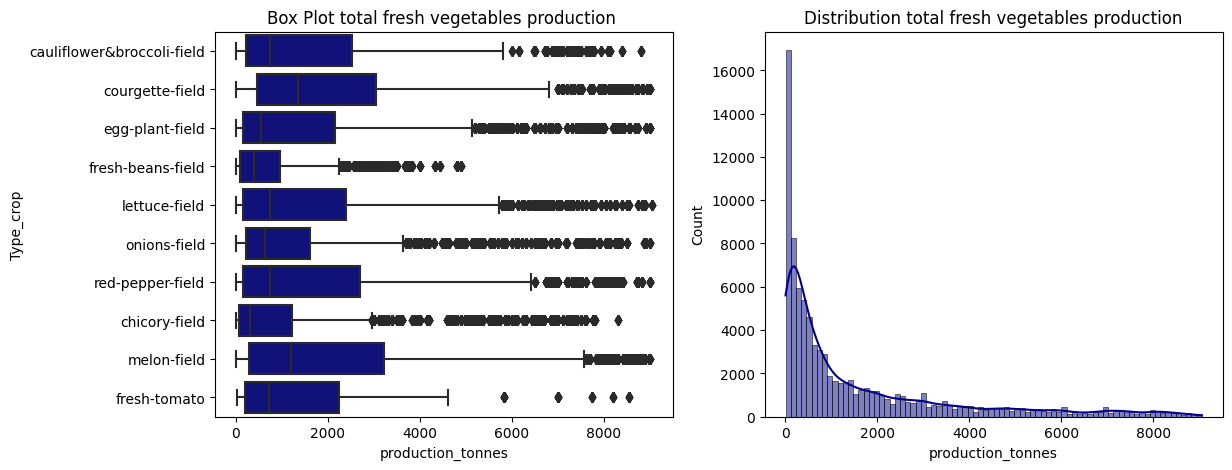

In [18]:
#Box plot and histplot (crop production distribuition)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.boxplot(data=fresh_veg_top10, x='production_tonnes', y="Type_crop",  color = 'darkblue', dodge=False)

plt.title(f'Box Plot total fresh vegetables production ')

plt.subplot(1,2,2)
sns.histplot(data=fresh_veg_top10, x= 'production_tonnes',  color = 'darkblue', kde=True, bins = 80)
plt.title(f'Distribution total fresh vegetables production')

plt.show()



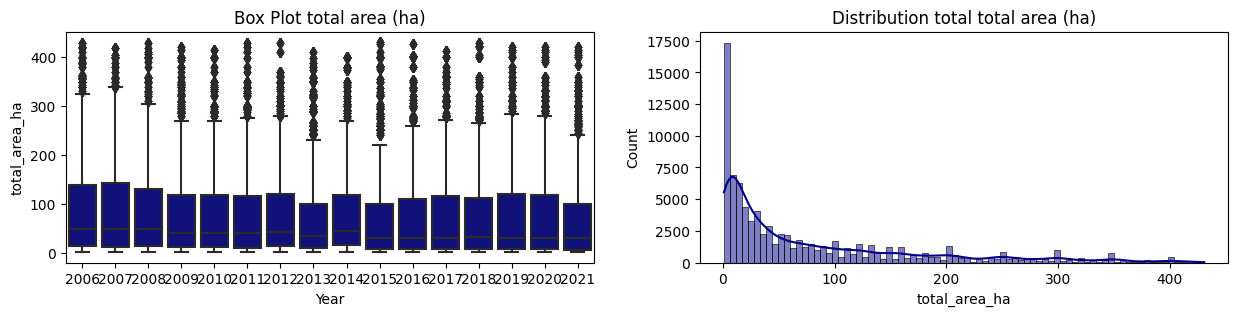

In [19]:
#Box plot and histplot of total area(ha)

plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
sns.boxplot(data=fresh_veg_top10, x='Year', y="total_area_ha",  color = 'darkblue', dodge=False)

plt.title(f'Box Plot total area (ha)')

plt.subplot(1,2,2)
sns.histplot(data=fresh_veg_top10, x= 'total_area_ha',  color = 'darkblue', kde=True, bins = 80)
plt.title(f'Distribution total total area (ha)')

plt.show()

In [20]:
print(fresh_veg_top10.total_area_ha.max())
print(fresh_veg_top10.total_area_ha.min())
print(fresh_veg_top10.total_area_ha.value_counts())
print(fresh_veg_top10.total_area_ha.nunique())

431.0
1.0
3.00      3525
2.00      3078
1.00      3044
5.00      2731
6.00      2552
          ... 
229.00       6
387.00       5
315.00       5
223.00       5
222.00       3
Name: total_area_ha, Length: 370, dtype: int64
370


In [21]:
print(fresh_veg_top10.Fertilizers_tonnes.max())


3473.6


<AxesSubplot: xlabel='Year', ylabel='Fertilizers_tonnes'>

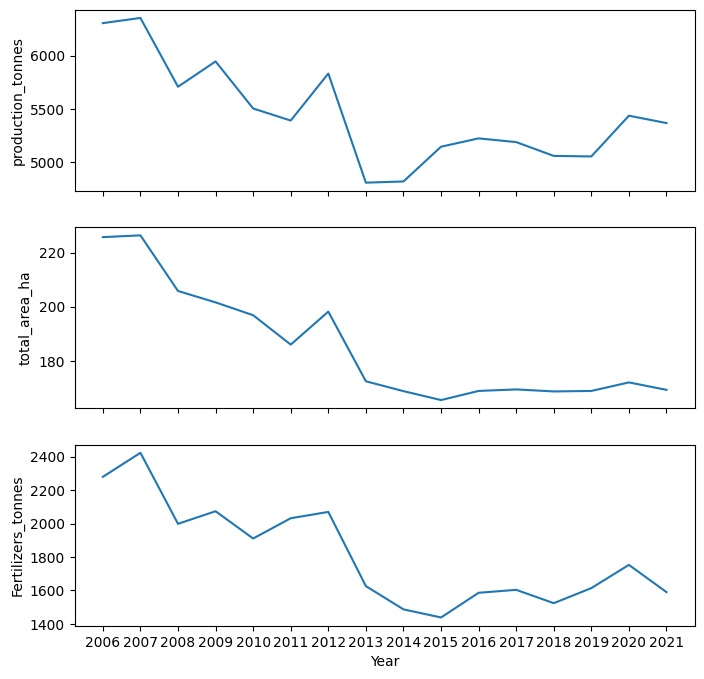

In [22]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,8))

fresh_veg['Year'] = (fresh_veg['Year']).astype(str)

# Total crop production
crops =fresh_veg[['Year', 'production_tonnes']]
crops = crops.groupby('Year').mean()
sns.lineplot(data= crops, x="Year", y="production_tonnes", ax=ax[0])

# Total area
crops =fresh_veg[['Year', 'total_area_ha']]
crops = crops.groupby('Year').mean()
sns.lineplot(data= crops, x="Year", y="total_area_ha", ax=ax[1])

# Ferlizers
fertilizers =fresh_veg[['Year', 'Fertilizers_tonnes']]
fertilizers = fertilizers.groupby('Year').mean()

sns.lineplot(data= fertilizers, x="Year", y="Fertilizers_tonnes", ax=ax[2])




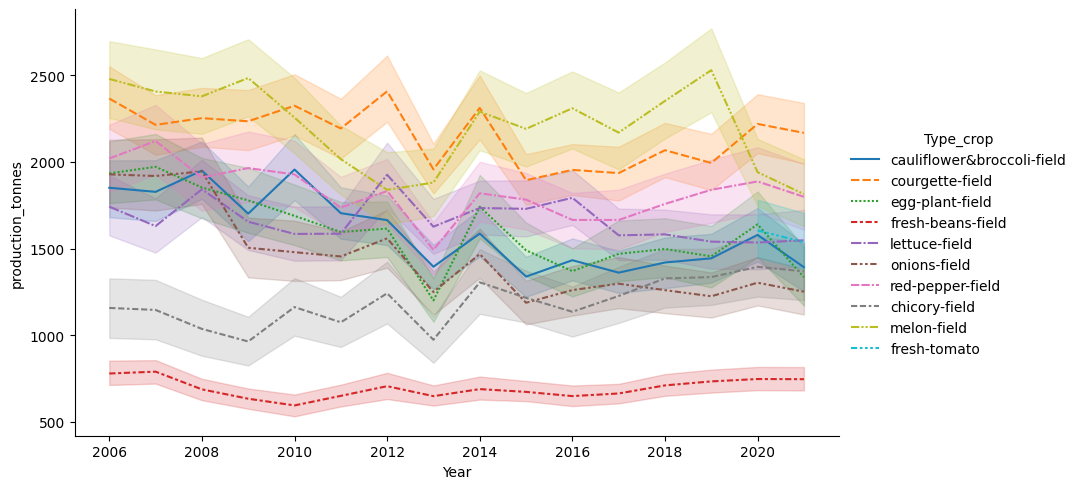

In [23]:
#Crop harvested by year

plotcrop10 = sns.relplot(kind='line', data=fresh_veg_top10, x='Year', 
                         y='production_tonnes', hue='Type_crop', style='Type_crop', aspect=1.75)


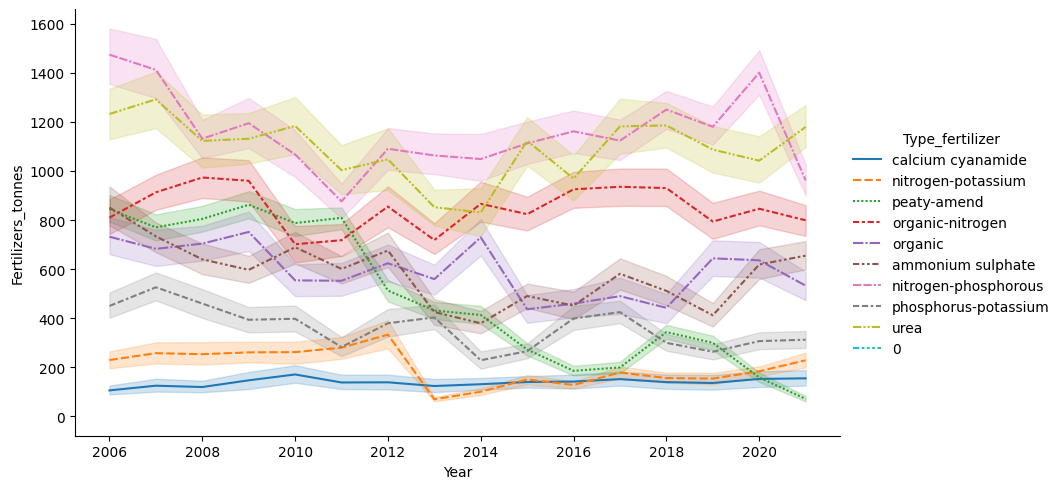

In [24]:
#Fertilizers distributed by year

plotfertilizers10 = sns.relplot(kind='line', data=fresh_veg_top10, x='Year', 
                         y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)

# Climate data analysis

|Param_Code|Param_Name|Resolution|Depth [m]|Units|
|:--------:|:--------:|:--------:|:-------:|:---:|
|GWETPROF|Profile Soil Moisture|0.5° x 0.625°|1.34 - 8.53|water-free [0], saturated soil[1]| 
|GWETTOP|Surface Soil Wetness|0.5° x 0.625°|0.00 - 0.05| water-free [0], saturated soil[1]|
|GWETROOT|Root Zone Soil Wetness|0.5° x 0.625°|0.10 - 1.00|water-free [0], saturated soil[1]|
|CLOUD_AMT|Cloud Amount|---|---|%|
|TS|Earth Skin Temperature|---|---|°C|
|PS|Surface Pressure|---|---|kPa|
|RH2M|Relative Humidity at 2 Meters|---|---|%|
|QV2M|Specific Humidity at 2 Meters|---|---|g/kg|
|PRECTOTCORR|Precipitation Corrected|---|---|mm/day|
|T2M_MAX|Temperature at 2 Meters Maximum|---|---|°C|
|T2M_MIN|Temperature at 2 Meters Minimum|---|---|°C|
|T2M_RANGE|Temperature at 2 Meters Range|---|---|°C|
|WS2M|Wind Speed at 2 Meters|---|---|m/s|


  

*Precipitation Corrected (PRECTOTCORR)- [The bias corrected average of total precipitation at the surface of the earth in water mass (includes water content in snow)]

*Source? https://power.larc.nasa.gov/#resources

<AxesSubplot: xlabel='Year', ylabel='GWETROOT'>

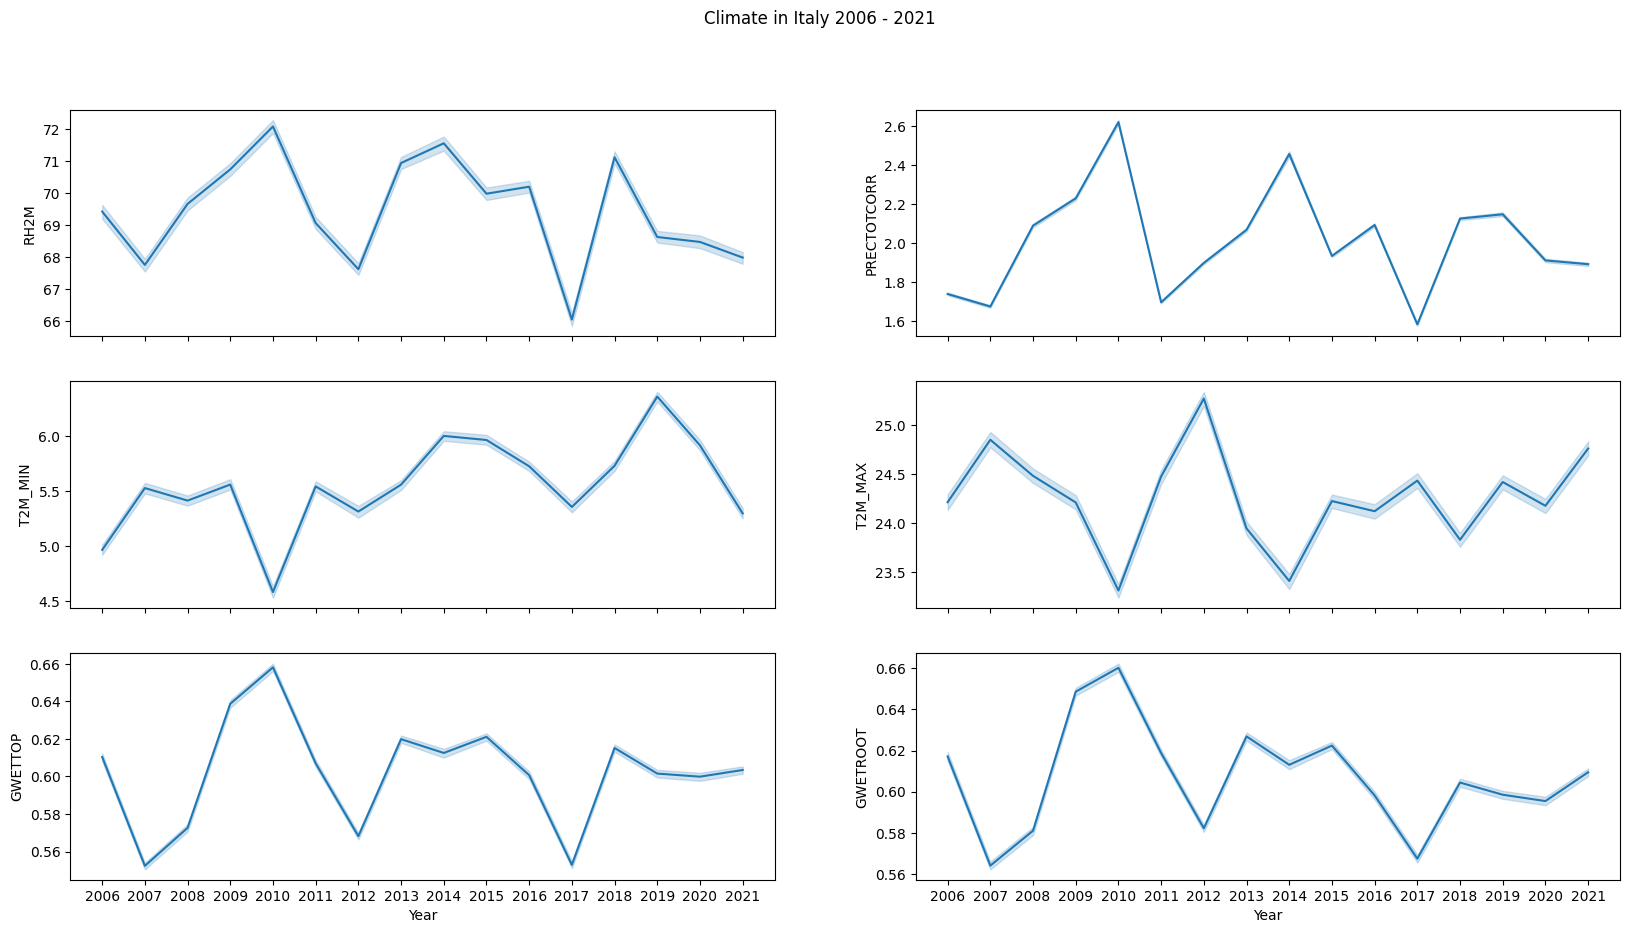

In [25]:

fig, ax = plt.subplots(3, 2, sharex=True, figsize=(20,10))

fig.suptitle('Climate in Italy 2006 - 2021')

fresh_veg['Year'] = (fresh_veg['Year']).astype(str)

# relative_humidity
sns.lineplot(data=fresh_veg, x="Year", y="RH2M", ax=ax[0,0])

# precipitation
sns.lineplot(data=fresh_veg, x="Year", y="PRECTOTCORR", ax=ax[0,1])

# temp_max
sns.lineplot(data=fresh_veg, x="Year", y="T2M_MIN", ax=ax[1,0])

# temp_min
sns.lineplot(data=fresh_veg, x="Year", y="T2M_MAX", ax=ax[1,1])

# surface_soil_wetness
sns.lineplot(data=fresh_veg, x="Year", y="GWETTOP", ax=ax[2,0])

# root_zone_wetness
sns.lineplot(data=fresh_veg, x="Year", y="GWETROOT", ax=ax[2,1])


In [26]:
fresh_veg_model =fresh_veg_top10.drop(columns =['Year','PS','TS','GWETTOP', 'QV2M','WS2M','T2M_RANGE','GWETPROF','CLOUD_AMT','PRECTOTCORR','lat', 'lon'  ])
fresh_veg_model

City                   Type_crop  production_tonnes  \
30                  Agrigento  cauliflower&broccoli-field            6708.00   
31                  Agrigento  cauliflower&broccoli-field            6708.00   
32                  Agrigento  cauliflower&broccoli-field            6708.00   
33                  Agrigento  cauliflower&broccoli-field            6708.00   
34                  Agrigento  cauliflower&broccoli-field            6708.00   
...                       ...                         ...                ...   
522700  Monza e della Brianza            red-pepper-field              22.00   
522701  Monza e della Brianza            red-pepper-field              22.00   
522702  Monza e della Brianza            red-pepper-field              22.00   
522703  Monza e della Brianza            red-pepper-field              22.00   
522705  Monza e della Brianza            red-pepper-field              22.00   

        total_area_ha  RH2M  T2M_MAX  T2M_MIN  GWETROOT       Type_fertilizer  \
30             312.00 71.95    28.51     6.77      0.62     calcium cyanamide   
31             312.00 71.95    28.51     6.77      0.62    nitrogen-potassium   
32             312.00 71.95    28.51     6.77      0.62           peaty-amend   
33             312.00 71.95    28.51     6.77      0.62      organic-nitrogen   
34             312.00 71.95    28.51     6.77      0.62               organic   
...               ...   ...      ...      ...       ...                   ...   
522700           1.00 72.07    24.09     3.30      0.71  phosphorus-potassium   
522701           1.00 72.07    24.09     3.30      0.71               organic   
522702           1.00 72.07    24.09     3.30      0.71                  urea   
522703           1.00 72.07    24.09     3.30      0.71      organic-nitrogen   
522705           1.00 72.07    24.09     3.30      0.71     calcium cyanamide   

        Fertilizers_tonnes  
30                    0.00  
31                   27.70  
32                  174.50  
33                  760.50  
34                 1343.70  
...                    ...  
522700               10.00  
522701               51.00  
522702             1421.00  
522703               17.00  
522705                0.00  

[87797 rows x 10 columns]

# Pre-processing data for modelling 

In [27]:
from pycaret.regression import *

In [28]:
regr = setup(data =fresh_veg_model, target = 'production_tonnes', session_id = 123,
             categorical_features= ['City', 'Type_crop','Type_fertilizer'], normalize = True )

In [29]:
best = compare_models()

In [30]:
et = create_model('et')

# Tune model


In [ ]:
tuned_et = tune_model(et)

In [ ]:
#evaluate_model(et)

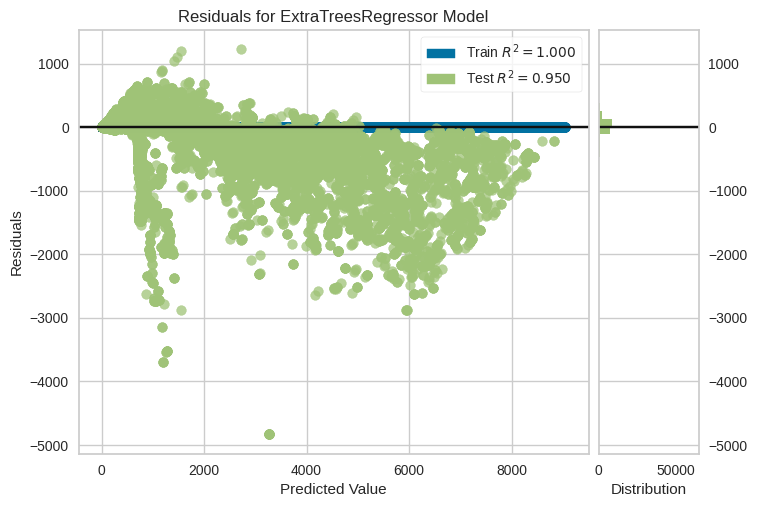

In [31]:
plot_model(et) 

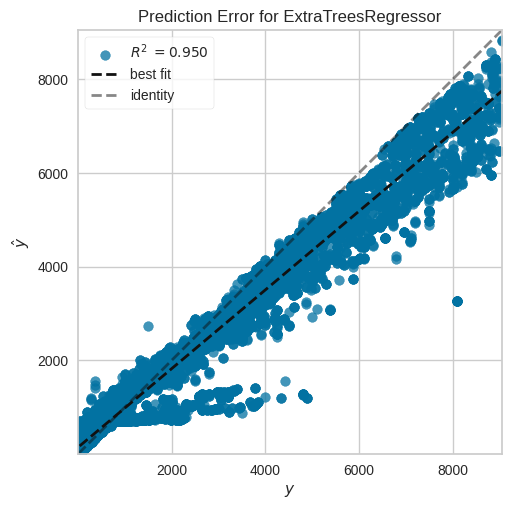

In [32]:
plot_model(et, plot = 'error')


In [33]:
plot_model(et, plot = 'parameter')


Parameters
bootstrap                         False
ccp_alpha                           0.0
criterion                 squared_error
max_depth                          None
max_features                        1.0
max_leaf_nodes                     None
max_samples                        None
min_impurity_decrease               0.0
min_samples_leaf                      1
min_samples_split                     2
min_weight_fraction_leaf            0.0
n_estimators                        100
n_jobs                               -1
oob_score                         False
random_state                        123
verbose                               0
warm_start                        False

# Predict Model

In [34]:
predictions = predict_model(et)

In [36]:
final_et = finalize_model(et)

In [37]:
print(final_et)


Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['total_area_ha', 'RH2M', 'T2M_MAX',
                                             'T2M_MIN', 'GWETROOT',
                                             'Fertilizers_tonnes'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['City', 'Type_crop',
                                             'Type_fertilizer'],
                                    transformer=SimpleImputer(fill_value='constant',
                                                              strate...
                                             'Type_fertilizer'],
                                    transformer=LeaveOneOutEncoder(cols=['City',
                                                                         'Type_crop',
                                                                        

In [38]:
save_model(final_et, 'fresh_veg_et')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['total_area_ha', 'RH2M', 'T2M_MAX',
                                              'T2M_MIN', 'GWETROOT',
                                              'Fertilizers_tonnes'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['City', 'Type_crop',
                                              'Type_fertilizer'],
                                     transformer=SimpleImputer(fill_value='constant',
                                                               strate...
                                              'Type_fertilizer'],
                                     transformer=LeaveOneOutEncoder(cols=['City',
                                                                          'Type_crop',
                                                          

In [39]:
new_data = fresh_veg_model.copy()
new_data.drop(['production_tonnes'], axis=1, inplace=True)
predict_new = predict_model(final_et, data=new_data)
predict_new.head()


City  Type_crop  total_area_ha  RH2M  T2M_MAX  T2M_MIN  GWETROOT  \
0  1.99       0.01           2.50 -0.30     1.54     0.26     -0.08   
1  1.99       0.01           2.50 -0.30     1.54     0.26     -0.08   
2  1.99       0.01           2.50 -0.30     1.54     0.26     -0.08   
3  1.99       0.01           2.50 -0.30     1.54     0.26     -0.08   
4  1.99       0.01           2.50 -0.30     1.54     0.26     -0.08   

   Type_fertilizer  Fertilizers_tonnes  prediction_label  
0             0.86               -0.70           5924.35  
1             0.60               -0.66           5924.35  
2            -0.07               -0.47           5924.35  
3             0.05                0.28           5915.12  
4            -0.10                1.02           5916.43

In [40]:
new_data.Type_crop.unique()

array(['cauliflower&broccoli-field', 'courgette-field', 'egg-plant-field',
       'fresh-beans-field', 'lettuce-field', 'onions-field',
       'red-pepper-field', 'chicory-field', 'melon-field', 'fresh-tomato'],
      dtype=object)

In [41]:
new_data.City.unique()

array(['Agrigento', 'Alessandria', 'Ancona', 'Arezzo', 'Ascoli Piceno',
       'Asti', 'Avellino', 'Bari', 'Belluno', 'Benevento', 'Bergamo',
       'Biella', 'Bologna', 'Brescia', 'Brindisi', 'Caltanissetta',
       'Campobasso', 'Caserta', 'Catania', 'Catanzaro', 'Chieti',
       'Cosenza', 'Cremona', 'Crotone', 'Enna', 'Ferrara', 'Firenze',
       'Foggia', 'Frosinone', 'Genova', 'Gorizia', 'Grosseto', 'Imperia',
       'Isernia', 'La Spezia', 'Latina', 'Lecce', 'Livorno', 'Lodi',
       'Lucca', 'Macerata', 'Mantova', 'Matera', 'Messina', 'Milano',
       'Modena', 'Napoli', 'Novara', 'Nuoro', 'Oristano', 'Padova',
       'Palermo', 'Parma', 'Pavia', 'Perugia', 'Pesaro e Urbino',
       'Pescara', 'Piacenza', 'Pisa', 'Pistoia', 'Pordenone', 'Potenza',
       'Prato', 'Ragusa', 'Ravenna', 'Reggio di Calabria',
       "Reggio nell'Emilia", 'Rimini', 'Roma', 'Rovigo', 'Salerno',
       'Sassari', 'Savona', 'Siena', 'Siracusa', 'Taranto', 'Teramo',
       'Terni', 'Torino', 'Trapani', 

In [42]:
new_data.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrogen-potassium', 'peaty-amend',
       'organic-nitrogen', 'organic', 'ammonium sulphate',
       'nitrogen-phosphorous', 'phosphorus-potassium', 'urea', '0'],
      dtype=object)

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html

https://www.statisticshowto.com/variance-inflation-factor/

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

https://lost-stats.github.io/Presentation/Figures/heatmap_colored_correlation_matrix.html

https://plotly.com/python/box-plots/

https://pycaret.org/